### **ML - Sistema de Recomendación**

**Importo las librerias requeridas**

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD

from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [2]:
# Creo un dataframe con los datos transformados.
url_1 = 'https://drive.google.com/uc?id=1Du_gvJUXktgUGZTi7dF7CHyR-R7H_U8m'
df_movie_score = pd.read_csv(url_1)

url_2 = 'https://drive.google.com/uc?id=1WKgEbecS7xL0bDIXjnPI73aIJ6QBWWzO'
df_score_id_user = pd.read_parquet(url_2)

In [10]:
# Del df_movie_score voy a tomar las columnas de 'id' y 'title'

df_title = df_movie_score.loc[:,('id','title')]
df_title

,id,title
0,as1,the grand seduction
1,as2,take care good night
2,as3,secrets of deception
3,as4,pink: staying true
4,as5,monster maker
...,...,...
22993,ns8803,zodiac
22994,ns8804,zombie dumb
22995,ns8805,zombieland
22996,ns8806,zoom


In [11]:
df_score_id_user

,id,userId,score
0,as680,1,1.0
1,ns2186,1,4.5
2,hs2381,1,5.0
3,ns3663,1,5.0
4,as9500,1,5.0
...,...,...,...
11013818,ns5272,124380,4.5
11013819,ns5492,124380,2.5
11013820,hs305,124380,3.5
11013821,ns7881,124380,4.5


Modelado con dataset df_score_id_user completo

In [40]:
# Modelo con el total de los valores de score

reader = Reader(rating_scale=(0.5,5))

data = Dataset.load_from_df(df_score_id_user, reader=reader)

In [41]:
# Separamos nuestros datos
trainset, testset = train_test_split(data, test_size=0.25)

In [42]:
# Uso el modelo de Singular Value Decomposition
algo = SVD()

In [43]:
# Entreno el modelo
algo.fit(trainset)

In [44]:
# Hago la predicción con los datos testeados
predictions = algo.test(testset)

In [45]:
# Hago la predicción con un userId, una id al azar y un score al azar
user_id = '124380'
muvi_id = 'ns5272'
r_ui = 4.5
algo.predict(user_id, muvi_id, r_ui=r_ui, verbose=True)

user: 124380     item: ns5272     r_ui = 4.50   est = 3.53   {'was_impossible': False}


Prediction(uid='124380', iid='ns5272', r_ui=4.5, est=3.533552867566296, details={'was_impossible': False})

In [47]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv = 3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0009  1.0007  1.0017  1.0011  0.0004  
MAE (testset)     0.7764  0.7765  0.7771  0.7767  0.0003  
Fit time          160.82  198.18  201.79  186.93  18.52   
Test time         301.56  369.47  191.71  287.58  73.24   


{'test_rmse': array([1.00088731, 1.0007144 , 1.00172835]),
 'test_mae': array([0.77644054, 0.77653049, 0.77709484]),
 'fit_time': (160.82145047187805, 198.17664289474487, 201.7859969139099),
 'test_time': (301.5630090236664, 369.47217416763306, 191.71210885047913)}

Modelado con dataset df_score_id_user usando umbral

In [15]:
reader = Reader()

In [16]:
N_filas = 100000 # Limitamos el dataset a N_filas

reader = Reader(rating_scale=(0.5,5))

data = Dataset.load_from_df(df_score_id_user[['userId', 'id', 'score']][:N_filas], reader)

In [17]:
# Separo los datos
trainset, testset = train_test_split(data, test_size=.25)

In [18]:
# Uso un modelo de Singular Value Decomposition
model = SVD()

In [19]:
# Entreno el modelo
model.fit(trainset)

In [20]:
# Predigo
predictions = model.test(testset)

In [21]:
predictions[1]

Prediction(uid=607, iid='as5265', r_ui=2.0, est=2.7349859539805266, details={'was_impossible': False})

In [22]:
# Hacemos una predicción al azar para usuario y película
model.predict(124380,'ns5272')

Prediction(uid=124380, iid='ns5272', r_ui=None, est=3.324642025686626, details={'was_impossible': False})

In [23]:
# Tomo un usuario para hacerle una recomendación

usuario = 555
rating = 4   # Tomamos películas a las que haya calificado con 4 o 5 estrellas
df_user = df_score_id_user[(df_score_id_user['userId'] == usuario) & (df_score_id_user['score'] >= rating)]
df_user = df_user.reset_index(drop=True)
df_user

,id,userId,score
0,as432,555,4.5
1,ns2476,555,5.0
2,as4001,555,4.0
3,as589,555,4.0
4,as1501,555,5.0
5,as1831,555,5.0
6,hs2690,555,5.0
7,as5912,555,5.0
8,ns766,555,5.0
9,as1800,555,5.0


In [24]:
pd.merge(df_user,df_title,how='inner',on='id')

,id,userId,score,title
0,as432,555,4.5,the submarine kid
1,ns2476,555,5.0,si doel the movie 3
2,as4001,555,4.0,red metal: the copper country strike of 1913
3,as589,555,4.0,the kid from brooklyn
4,as1501,555,5.0,new york goes to hollywood
5,as1831,555,5.0,llamageddon
6,hs2690,555,5.0,how i met your mother
7,as5912,555,5.0,sucker punch
8,ns766,555,5.0,xtreme
9,as1800,555,5.0,love simple


In [25]:
recomendaciones_usuario = df_title.iloc[:20000].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(20000, 2)


,id,title
0,as1,the grand seduction
1,as2,take care good night
2,as3,secrets of deception
3,as4,pink: staying true
4,as5,monster maker


In [26]:
# Debo extraer las películas que ya ha visto
usuario_vistas = df_score_id_user[df_score_id_user['userId'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(18, 3)


,id,userId,score
52672,ns7837,555,0.5
52673,as432,555,4.5
52674,ns2476,555,5.0
52675,hs2776,555,3.0
52676,ds634,555,1.0


In [27]:
# Eliminamos las peliculas que el usuario ya vió
recomendaciones_usuario = recomendaciones_usuario[~recomendaciones_usuario['id'].isin(usuario_vistas['id'])]
recomendaciones_usuario.shape

(19983, 2)

In [28]:
# Recomiendo
recomendaciones_usuario['estimate_Score'] = recomendaciones_usuario['id'].apply(lambda x: model.predict(usuario, x).est)

In [29]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))

           id                   title  estimate_Score
9277   as9278   welcome to the jungle        4.385649
18936  ns4746      da kath & kim code        4.370683
19567  ns5377           chasing coral        4.370670
19292  ns5102          fun mom dinner        4.360147
17339  ns3149  what's new scooby-doo?        4.355545
2339   as2340        girls' last tour        4.346708
3429   as3430         a dangerous man        4.330784
4393   as4394    coimbatore mappillai        4.324171
8231   as8232       the wheel of time        4.320205
18693  ns4503        mr. chandramouli        4.311078


### **Modelo de Predicción ingresando un usuario (formato: userId) y una película (formato: id)**

In [30]:
def get_movie_recommendation(userId, id):
    # Obtenemos la predicción de la calificación que el usuario le daría a la película
    prediction = model.predict(userId, str(id))

    # Si la predicción es mayor o igual a 4, se recomienda la película
    if prediction.est >= 4:
        return "Recomendada", prediction.est
    else:
        return "No recomendada", prediction.est

In [35]:
# Ejemplo del funcionamiento de get_movie_recommendation

# ID del usuario
user_id = 432
# ID de la película
id = 'ns3149'

# Obtener la recomendación para el usuario y la película
recommendation = get_movie_recommendation(user_id, id)

# Imprimir la recomendación
print("La película es:", recommendation)

La película es: ('Recomendada', 4.036442978543465)


### **Evaluación**

In [36]:
# Evalúo accuracy del modelo

from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 0.9543


0.9543439564112763

## **Optimización de hiperparámetros**

a) Con dataset df_score_id_user completo


In [78]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128]

for factor in factores:
    print(factor)
    model = SVD(n_factors=factor)
    cv = cross_validate(model, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9666  0.9660  0.9651  0.9659  0.0006  
Fit time          117.44  117.90  115.57  116.97  1.01    
Test time         285.55  156.66  200.65  214.29  53.50   
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9668  0.9665  0.9672  0.9668  0.0003  
Fit time          101.67  111.12  109.82  107.54  4.18    
Test time         2927.58 202.29  451.86  1193.91 1230.12 
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9683  0.9680  0.9682  0.9682  0.0001  
Fit time          127.61  115.54  139.48  127.55  9.77    
Test time         465.27  242.73  429.03  379.01  97.49   
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9710  0.9

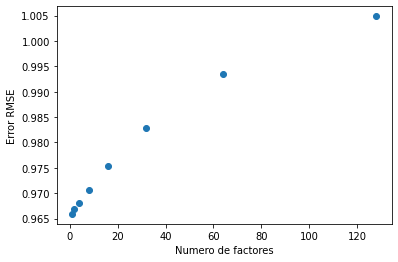

In [79]:
# Ploteamos desempeño según cantidad de factores de SVD

plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

b) Con dataset df_score_id_user con umbral

In [155]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(factor)
    model = SVD(n_factors=factor)
    cv = cross_validate(model, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9584  0.9552  0.9522  0.9553  0.0025  
Fit time          0.51    0.52    0.52    0.52    0.01    
Test time         0.19    0.20    0.20    0.20    0.00    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9559  0.9546  0.9558  0.9554  0.0006  
Fit time          0.54    0.55    0.53    0.54    0.01    
Test time         0.21    0.21    0.21    0.21    0.00    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9591  0.9543  0.9508  0.9547  0.0034  
Fit time          0.55    0.59    0.58    0.58    0.02    
Test time         0.44    0.21    0.20    0.28    0.11    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9619  0.9

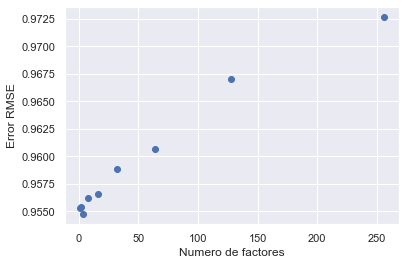

In [156]:
# Ploteo desempeño según cantidad de factores de SVD

plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [157]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

In [158]:
# Observo la performance del mejor modelo

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9484976149331708
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.002}


## **Gradio - Interfaz de Consulta**

In [41]:
# Creo una función para averiguar el nombre de película 

def get_title_movie(id):
    return df_title[df_title.id == id].title.iloc[0].title()

In [42]:
get_title_movie('as2340')

"Girls' Last Tour"

In [43]:
# Combino las funciones 'get_title_movie' y 'get_movie_recommendation'

def functions(userId, id):
    recommended, score = get_movie_recommendation(userId, id)
    title = get_title_movie(id)
    return (recommended, score, title)

In [44]:
functions(17339, 'as2340')

('No recomendada', 3.747965563677545, "Girls' Last Tour")

In [45]:
# Importo la libreria de gradio para hacer la interfaz
import gradio as gr

In [48]:
title = str("Recomendación de peliculas")

with gr.Blocks(title= title) as demo:
    text = gr.components.HTML("""
    <h1>Sistema de recomendación de películas. ¡¿Qué más ver?!</h1>
    """)
    userId = gr.inputs.Number(label="Ingresar id de usuario")
    id = gr.Textbox(label="Ingresar id de la película")
    get_recommendation_btn = gr.Button("La película seleccionada  para vos")
    title = gr.Textbox(label = "Nombre de la película:")
    output = gr.Textbox(label="¿La película seleccionada es recomendada para vos?")
    score = gr.Textbox(label="Predicción del puntaje:")
    get_recommendation_btn.click(fn=functions, inputs=[userId,id], outputs=[output, score, title])

demo.launch(share=True)

c:\Users\maric\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\inputs.py:59: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
c:\Users\maric\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://291b16deb86906980d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
